# Aprendizado por reforço

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
from functools import partial

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import gym

import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
tf.compat.v1.disable_eager_execution()

### Introdução OpenAI gym

In [3]:
env = gym.make('MsPacman-v0')
observacao = env.reset()
print(observacao.shape, '\n')
img = env.render(mode='rgb_array')

(210, 160, 3) 



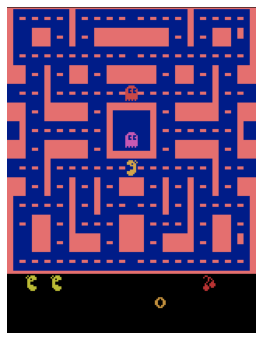

In [4]:
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Função auxiliar para traçar um ambiente

In [5]:
def plot_environment(env, figsize=(10, 6)):
    plt.close()
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
print(f'Espaço de ação: {env.action_space}')

Espaço de ação: Discrete(9)


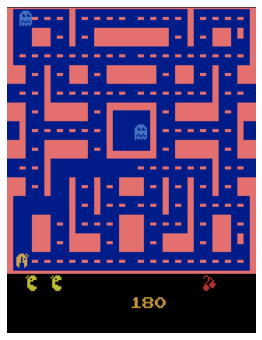

In [7]:
env.reset()
for step in range(110):
    env.step(3) #esquerda
for step in range(40):
    env.step(8) #inferior esquerda
    
plot_environment(env)

In [8]:
obs, reward, done, info = env.step(0)

A observação diz ao agente como é o ambiente:

In [9]:
obs.shape

(210, 160, 3)

O ambiente também informa ao agente quanta recompensa ele obteve durante a última etapa:

In [10]:
reward

0.0

Quando o jogo acaba, o ambiente retorna **done=True**:

In [11]:
done

False

O info é um dicionário específico do ambiente que pode fornecer algumas informações extras sobre o estado interno do ambiente. Isso é útil para depuração, mas seu agente não deve usar essas informações para aprendizado (seria trapaça).

In [12]:
info

{'ale.lives': 3}

#### Jogo completo com 3 vidas, movendo-nos em direções aleatórias por 10 etapas de cada vez, gravando cada quadro

In [13]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

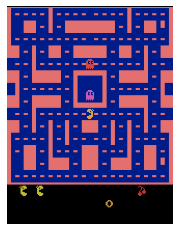

In [14]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode='rgb_array')
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break


video = plot_animation(frames)
plt.show()

In [15]:
env.close()

### Um ambiente simples: the Cart-Pole

In [16]:
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.03205541,  0.00267524, -0.04580721,  0.04114281])

#### Corrigindo o problema de renderização

In [17]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True
except Exception:
    openai_cart_pole_rendering = False

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode='rgb_array')
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

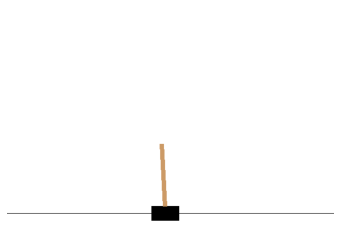

In [18]:
plot_cart_pole(env, obs)

In [19]:
print(f'Espaço de ação: {env.action_space}')

Espaço de ação: Discrete(2)


Empurrando o carrinho

(-0.5, 599.5, 399.5, -0.5)

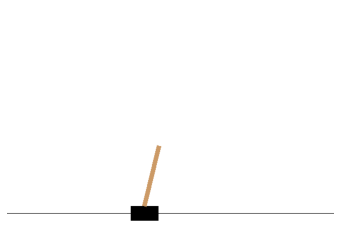

In [20]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

plt.close()
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis('off')

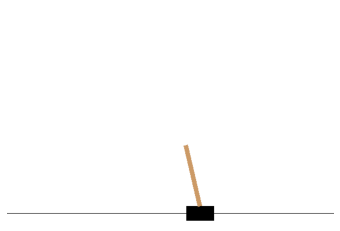

In [21]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

plot_cart_pole(env, obs)

Definindo uma política

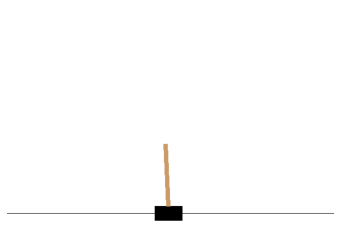

In [22]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

video = plot_animation(frames)
plt.show()

### Políticas de rede neural

Instructions for updating:
Use `tf.random.categorical` instead.


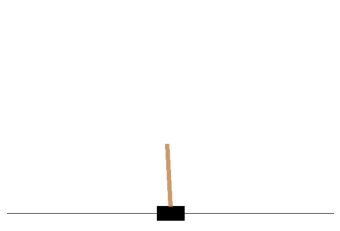

In [23]:
n_inputs = env.observation_space.shape[0]
n_hidden = 4
n_outputs = 1

initializer = tf.compat.v1.variance_scaling_initializer()


X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
outputs = tf.compat.v1.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=initializer)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.compat.v1.multinomial(tf.math.log(p_left_and_right), num_samples=1)

init = tf.compat.v1.global_variables_initializer()


n_max_steps = 1000
frames = []

with tf.compat.v1.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()


video = plot_animation(frames)
plt.show()

### Política de gradiente

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
n_inputs = 4
n_hidden = 4
n_outputs = 1
learning_rate = 0.01

initializer = tf.compat.v1.variance_scaling_initializer()


X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.compat.v1.layers.dense(hidden, n_outputs)
outputs = tf.compat.v1.nn.sigmoid(logits)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.compat.v1.multinomial(tf.math.log(p_left_and_right), num_samples=1)

init = tf.compat.v1.global_variables_initializer()

y = 1. - tf.compat.v1.to_float(action)
cross_entropy = tf.compat.v1.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

Instructions for updating:
Use `tf.cast` instead.


In [26]:
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars if grad != None]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
  if grad != None:
    gradient_placeholder = tf.compat.v1.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [27]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [28]:
env = gym.make('CartPole-v0')

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print('\rIteration: {}'.format(iteration), end='')
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt')

env.close()

Iteration: 249

In [29]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make('CartPole-v0')
    obs = env.reset()
    with tf.compat.v1.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt


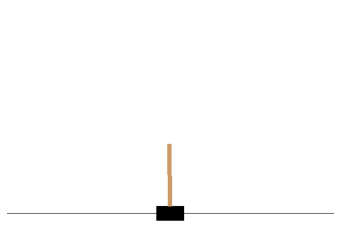

In [30]:
frames = render_policy_net('/content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt', action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

### Cadeias de Markov

In [32]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # de s0 para s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # de s1 para s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # de s2 para s2, s3
        [0.0, 0.0, 0.0, 1.0],  # de s3 para s3
]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print('States:', end=' ')
    for step in range(n_max_steps):
        print(current_state, end=' ')
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print('...', end='')
    print()

for _ in range(10):
    print_sequence()

States: 0 0 0 0 0 3 
States: 0 0 0 0 0 0 1 3 
States: 0 3 
States: 0 0 0 0 1 3 
States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 3 
States: 0 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 


### Processo de decisão de Markov

In [33]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # em s0, se a ação a0, então prob 0,7 p/ o estado s0 e 0,3 p/ o estado s1...
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print('States (+rewards):', end=' ')
    for step in range(n_steps):
        if display:
            if step == 10:
                print('...', end=' ')
            elif step < 10:
                print(env.state, end=' ')
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print('({})'.format(reward), end=' ')
    if display:
        print('Total rewards =', env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print('Summary: mean={:.1f}, std={:1f}, min={}, max={}'.format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), 
                                                                   np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 250
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = -90
States (+rewards): 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 ... Total rewards = 140
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) ... Total rewards = -80
States (+rewards): 0 (10) 0 1 (-50) 2 2 1 (-50) 2 (40) 0 1 (-50) 2 (40) ... Total rewards = 20
Summary: mean=122.0, std=128.364635, min=-350, max=550

policy_random
States (+rewards): 0 0 0 0 (10) 0 0 1 1 1 1 (-50) ... Total rewards = -130
States (+rewards): 0 (10) 0 0 0 0 0 (10) 0 0 0 0 ... Total rewards = -50
States (+rewards): 0 0 0 (10) 0 1 1 1 1 1 (-50) 2 (40) ... Total rewards = 120
States (+rewards): 0 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 0 0 (10) 0 ... Total rewards = 140
States (+rewards): 0 0 1 (-50) 2 (40) 0 (10) 0 0 0 0 0 ... Total rewards = -30
Summary: mean=-

### Q-Values

In [43]:
nan = np.nan #representa ações impossíveis

T = np.array([ #shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]]
    ])

R = np.array([
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [nan, nan, nan], [0, 0, -50]],
        [[nan, nan, nan], [+40, 0, 0], [nan, nan, nan]]
    ])

possible_actions = [[0, 1, 2], [0, 2], [1]]

Q = np.full((3, 3), -np.inf) #-inf para ações impossíveis

for state, actions in enumerate(possible_actions):
  Q[state, actions] = 0.0 #Valor inicial - 0.0 ṕ/ todas as ações possíveis

discount_rate = 0.95
n_iterations = 100

for interation in range(n_iterations):
  Q_prev = Q.copy()
  for s in range(3):
    for a in possible_actions[s]:
      Q[s, a] = np.sum([T[s, a, sp] * (R[s, a, sp] + discount_rate * np.max(Q_prev[sp])) for sp in range(3)])

In [44]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [45]:
np.argmax(Q, axis=1) #no estado S0, escolha a0, no S1, escolha a2 e no S2, escolha a1.

array([0, 2, 1])

### Q-Learning

In [34]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99

exploration_policy = policy_random

q_values = np.full((n_states, n_actions), -np.inf)

for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()

for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # política gananciosa
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

def optimal_policy(state):
    return np.argmax(q_values[state])
q_values

array([[43.40390802, 41.52537991, 37.64793212],
       [23.38243823,        -inf, 24.52213512],
       [       -inf, 75.87584985,        -inf]])

In [35]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print('Summary: mean={:.1f}, std={:1f}, min={}, max={}'.format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 90
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) ... Total rewards = 300
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 60
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 1 (-50) 2 (40) 0 ... Total rewards = 120
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -10
Summary: mean=122.9, std=139.806854, min=-400, max=610

